In [1]:
import sys

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import cm


plt.style.use("small.style")

from matplotlib import patches

import numpy as np
from scipy import interpolate

import astropy
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM

In [2]:
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)
print cosmo


def comoving_distance(z):
    return cosmo.comoving_distance(z).value

def age(z):
    return cosmo.age(z).value

def lookback_time(z):
    return cosmo.lookback_time(z).value

def redshift(z):
    return z

radial_scale = comoving_distance


FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)


In [3]:
def radial(ax, r0, r1, angle, label=None, plot=True, **plotparams):
    sintheta = np.sin(angle*np.pi/180)
    costheta = np.cos(angle*np.pi/180)
    y0 = r0*sintheta
    y1 = r1*sintheta
    x0 = r0*costheta
    x1 = r1*costheta
    if plot:
        ax.plot([x0,x1],[y0,y1],**plotparams)
    if label:
        ax.text(x1,y1,label,rotation=angle,horizontalalignment='right',color='navy')
    return np.array([(x0,y0),(x1,y1)])
    
def arc(ax, r, angle, orientation=0, step=0.5, cut=False, plot=True, **plotparams):
    """ """
    n = int(angle / step) + 1
    theta = (np.linspace(-1,1,n) * angle / 2. + orientation) * np.pi/180.
    x = np.cos(theta) * r
    y = np.sin(theta) * r
    
    if cut>0:
        ii = (y<cut)&(y>0)
        x = x[ii]
        y = y[ii]
    if plot:
        ax.plot(x, y, **plotparams)
    return np.transpose([x, y])
    
    
def wedge(ax, angle=20, orientation=0, zmin=0.5, zmax=2, rmin=None, rmax=None, close=True, label=None, edges=True, fill=False, facecolor='w', **plotparams):
    """ """
    if rmin:
        r0 = rmin
        r1 = rmax
    else:
        r0 = radial_scale(zmin)
        r1 = radial_scale(zmax)
    
    seg1 = radial(ax, r0, r1, orientation + angle/2.,label=label, plot=edges, **plotparams)
    seg2 = radial(ax, r0, r1, orientation - angle/2.,plot=edges, **plotparams)
    arc1 = arc(ax, r0, angle, orientation,plot=edges,  **plotparams)
    arc2 = arc(ax, r1, angle, orientation, plot=close&edges, **plotparams)
    
    if fill:
        poly = np.vstack([seg1,arc2[::-1],seg2[::-1],arc1])
        p = patches.Polygon(poly, facecolor=facecolor, edgecolor=facecolor)
        ax.add_artist(p)
        
def gradient_wedge(ax, angle=20, orientation=0, zmin=0.5, zmax=2, close=True, label=None, steps=100, cmap="Blues_r", **plotparams):
    """ """
    
    r0 = radial_scale(zmin)
    r1 = radial_scale(zmax)
    
    sm = cm.ScalarMappable(norm=colors.Normalize(r0,r1), cmap=plt.get_cmap(cmap))
    
    rr = np.linspace(r0,r1,steps)
    for i in range(len(rr)-1):
        r = (rr[i]+rr[i+1])/2.
        c = sm.to_rgba(r)
        wedge(ax, angle, orientation, rmin=rr[i], rmax=rr[i+1], edges=False, fill=True, facecolor=c)

    
# def trunc(x, prec):
#     return int(x/10**prec)*10**prec
    
def scale(ax, z0, z1, func, nsteps=10, y=-300, step=1, minorstep=0.5, title="", label_range=None, **plotparams):
    """ """
    r0 = radial_scale(z0)
    r1 = radial_scale(z1)

    plt.plot([r0,r1],[y,y],**plotparams)
    
    ax.text(0,y-50,title,verticalalignment='top')

    
    zz = np.linspace(0, 11, 1000)
    scale_at_z = radial_scale(zz)
    interper = interpolate.interp1d(func(zz), scale_at_z)
    
    a = func(z0)
    b = func(z1)

    if b < a:
        a,b = b,a
    tick_labels = np.arange(0, b+step, step)
    ii = (tick_labels>a)&(tick_labels<b)
    tick_labels = tick_labels[ii]
    
    tick_pos = interper(tick_labels)
    
    for i in range(len(tick_labels)):
        r = tick_pos[i]
        ax.plot([r, r], [y-50, y], c='k')
        if (tick_labels[i]>=label_range[0])&(tick_labels[i]<=label_range[1]):
            ax.text(r, y-50, "%g"%tick_labels[i], rotation=0, verticalalignment='top', horizontalalignment='center')
        
    tick_labels = np.arange(0, b+minorstep, minorstep)
    ii = (tick_labels>a)&(tick_labels<b)
    tick_labels = tick_labels[ii]
    
    tick_pos = interper(tick_labels)
    
    for i in range(len(tick_labels)):
        r = tick_pos[i]
        ax.plot([r, r], [y-25, y], c='k')



In [8]:
def plot_sdss(ax, path="data/main_granett.csv",orientation=45,**plotparams):
    """ """
    cat = np.loadtxt(path,delimiter=",",skiprows=1,unpack=True)
    z,ra,dec = cat[2:5]
    r = radial_scale(z)
    theta = (ra+orientation)*np.pi/180
    x = np.cos(theta)*r
    y = np.sin(theta)*r
    
    ii = (x>0)&(y>50)
    ax.scatter(x[ii],y[ii],**plotparams)
    
    

    print >>sys.stderr, "Plotted SDSS",path
    
def plot_vipers(ax, path="data/w1_spec_radec.txt",zmin=0.3,zmax=1.2, orientation=45,label="VIPERS", **plotparams):
    """ """
    cat = np.loadtxt(path,unpack=True)
    ra,dec,z = cat
    ii = (z > zmin)&(z < zmax)
    ra = ra[ii]
    dec = dec[ii]
    z = z[ii]
    r = radial_scale(z)
    theta = (ra+orientation)*np.pi/180
    x = np.cos(theta)*r
    y = np.sin(theta)*r
    ax.scatter(x,y,**plotparams)
    
    wedge(ax, ra.max()-ra.min()+1, (ra.max()+ra.min())/2+orientation, label=label, zmin=0.4, zmax=1.2, c='k')
    
    print "vipers direction", ra.max()-ra.min()+1, (ra.max()+ra.min())/2+orientation
    
    print >>sys.stderr, "Plotted VIPERS",path

def plot_pfs(ax, path="data/3837.fits", zmin=0.7, zmax=1.2, orientation=45, label="PFS", **plotparams):
    """ """
    with fits.open(path, memmap=False) as hdul:
        data = hdul[-1].data
        ra = data['ra_gal']
        dec = data['dec_gal']
        z = data['observed_redshift_gal']
        sel = (z>zmin)&(z<zmax)&(ra < 8)
        ra = ra[sel]
        dec = dec[sel]
        z = z[sel]
        
#         o = np.random.uniform(0,1,len(z)).argsort()[:10000]
#         ra = ra[o]
#         dec = dec[o]
#         z = z[o]        
        ra -= 4
        
        r = radial_scale(z)
        theta = (ra+orientation)*np.pi/180
        x = np.cos(theta)*r
        y = np.sin(theta)*r
        
        sig = (r.max()-r.min())/2.
        sf = np.exp(-(r - r.min())**2/2./sig**2)
        sf /= sf.max()
        sel = np.random.uniform(0,1,len(r))<sf
        
        ax.scatter(x[sel],y[sel],**plotparams)

        print >>sys.stderr, "Plotted PFS",path
        
def plot_dawn(ax, path="data/3837.fits", zmin=1.5, zmax=9, orientation=45, label="PFS", **plotparams):
    """ """
    with fits.open(path, memmap=False) as hdul:
        data = hdul[-1].data
        ra = data['ra_gal']
        dec = data['dec_gal']
        z = data['observed_redshift_gal']
        
                
        ra -= (ra.min()+ra.max())/2.
        
        r = radial_scale(z)
        theta = ra*np.pi/180
        x = np.cos(theta)*r +  radial_scale(0.9)
        y = np.sin(theta)*r
        
        theta = np.arctan2(y, x)
        r = np.sqrt(x**2+y**2)*1.05
        
        ii = np.abs(theta) < 2.5*np.pi/180

        print r.min(), radial_scale(zmin)
        
        ii = np.logical_and(ii, r > radial_scale(zmin))
        
        theta = theta[ii]
        r = r[ii]
        theta += orientation*np.pi/180
        
        x = np.cos(theta)*r
        y = np.sin(theta)*r
        
        sig = (r.max()-r.min())/3.
        sf = np.exp(-(r - r.min())**2/2./sig**2)
        sf /= sf.max()*2
        sel = np.random.uniform(0,1,len(r))<sf

        x = x[sel]
        y = y[sel]
        r = r[sel]
        s = (r*1./np.mean(r))**5
        s[s<1] = 1
        print s.min(),s.max()
        ax.scatter(x,y,s=s,**plotparams)

        print >>sys.stderr, "Plotted dawn",path


Plotted PFS data/3837.fits


3273.9410099523493 4363.85576623
1.0 9.744170703328859


Plotted dawn data/3837.fits


3273.9410099523493 4363.85576623
1.0 9.84911050868899


Plotted dawn data/3837.fits
Plotted SDSS data/main_granett.csv
Plotted SDSS data/LRGagain_granett.csv


vipers direction 9.559586 27.969054


Plotted VIPERS data/w1_spec_radec.txt


vipers direction 6.343821999999989 399.21710299999995


Plotted VIPERS data/w4_spec_radec.txt


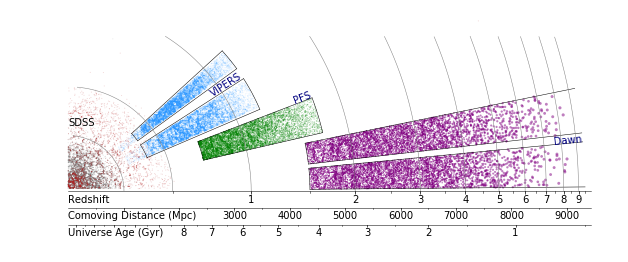

In [9]:
plt.figure(figsize=(8,4))
ax = plt.subplot(111, aspect='equal')

wedge(ax, 8, zmin=0.7, zmax=1.7, orientation=17, c='k', label="PFS")
wedge(ax, 5, zmin=1.5, zmax=9.5, orientation=9, close=False, c='k', label=None)
wedge(ax, 5, zmin=1.5, zmax=9.5, orientation=3, close=False, c='k', label="Dawn")

# gradient_wedge(ax, 8, zmin=0.7, zmax=1.7, orientation=17, c='k',fill=True,cmap='BuGn_r', label="PFS")
# gradient_wedge(ax, 5, zmin=1.5, zmax=9.5, orientation=9, close=False, c='k',fill=True,cmap='RdPu_r', label=None)
# gradient_wedge(ax, 5, zmin=1.5, zmax=9.5, orientation=3, close=False, c='k',fill=True,cmap='RdPu_r', label="Dawn")

scale(ax, 0, 10, redshift, step=1, minorstep=0.5, label_range=(1,10), title="Redshift", y=0, c='k')
scale(ax, 0, 10, comoving_distance, step=1000, minorstep=500,  label_range=(3000,9000), title="Comoving Distance (Mpc)", y=-300, c='k')
scale(ax, 0, 10, age,title="Universe Age (Gyr)", step = 1, minorstep=0.5, label_range=(0,8), y=-600, c='k')
# scale(ax, 0, 10, lookback_time,title="Lookback time Age (Gyr)", step = 0.5, y=-1300, c='g')

plot_pfs(ax, zmin=0.7, zmax=1.7, orientation=17, alpha=0.3,s=1,edgecolor='None', c='g', label="PFS")

plot_dawn(ax, zmin=1.5, zmax=9, orientation=3, alpha=0.5,edgecolor='None', c='purple', label="Dawn")
plot_dawn(ax, zmin=1.5, zmax=9, orientation=9, alpha=0.5,edgecolor='None', c='purple', label="Dawn")

plot_sdss(ax, c='grey',alpha=0.2,s=1,edgecolor='None')
plot_sdss(ax, path="data/LRGagain_granett.csv", c='firebrick',alpha=0.2,s=1,edgecolor='None')
plot_vipers(ax, path="data/w1_spec_radec.txt", orientation=-6.5, c='dodgerblue',alpha=0.1,s=1,edgecolor='None')
plot_vipers(ax, path="data/w4_spec_radec.txt", orientation=66.5, label=None, c='dodgerblue',alpha=0.1,s=1,edgecolor='None')

arc(ax, radial_scale(0.5), 90, orientation=40,step=0.1, cut=2800, c='grey')
arc(ax, radial_scale(0.25), 90, orientation=40,step=0.1, cut=2800, c='grey')
for z in range(1,10):
    arc(ax, radial_scale(z), 90, orientation=40, step=0.1, cut=2800, c='grey')

plt.text(0,radial_scale(0.3),"SDSS",color='k')
    
ax.axis('off')

plt.subplots_adjust(left=0,right=1, bottom=0, top=1)
# plt.savefig("dawn.pdf")
plt.savefig("dawn.png", dpi=300)
